In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pyhard.classification import ClassifiersPool
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler   # For oversampling
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import csv

filtering_threshold = [round(1 - 0.1 * i, 2) for i in range(6)]
thresholds = [round(0.5+0.02*i,2) for i in range(26)]

base_bst = XGBClassifier(
learning_rate=0.01,
n_estimators=1000,
max_depth=8,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective='binary:logistic',
eval_metric='logloss',
scale_pos_weight=1,
seed=27
)

colors = sns.color_palette("dark")

rosa = colors[6]

In [18]:
class SamplesBuilder:
    def __init__(self, csv_path, name, splits_dir="output_splits"):
        """
        Initialize the SamplesBuilder with a CSV path and output directory.

        Parameters:
        - csv_path (str): Path to the input CSV file.
        - output_dir (str): Directory to save the generated splits.
        """
        self.csv_path = csv_path
        self.splits_dir = splits_dir
        self.data = pd.read_csv(csv_path)
        self.splits = {}  # To store train/validation splits for each seed
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.splits_dir, exist_ok=True)

    @staticmethod
    def impute_missing(train, n_neighbors=3):
        """
        Static method to impute missing values using the K-nearest neighbors algorithm.
        """
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_data = imputer.fit_transform(train)
        imputed_df = pd.DataFrame(imputed_data, columns=train.columns, index=train.index)
        return imputed_df

    @staticmethod
    def ih_measure(train):
        """
        Static method to measure instance hardness.
        """
        # Call the static impute_missing method
        train = SamplesBuilder.impute_missing(train)

        # Placeholder for ClassifiersPool logic
        pool = ClassifiersPool(train)
        pool.run_all(
            metric='logloss',
            n_folds=5,
            algo_list=['svc_linear', 'random_forest'],
            n_iter=5,
            resampling='under',
            hyper_param_optm=False,
        )

        ih_measures = pool.estimate_ih()
        ih_measures_flat = ih_measures.flatten()
        ih_measures_series = pd.Series(ih_measures_flat, name='ih', index=train.index)

        merged_df = pd.concat([train.reset_index(drop=True), ih_measures_series.reset_index(drop=True)], axis=1)
        return merged_df

    def split_samples(self, seeds=[42, 43, 44, 45, 46]):
        """
        Split the data into train and validation sets using multiple seeds and save them to CSV.
        
        Parameters:
        - seeds (list): List of random seeds to generate splits.
        """
        for seed in seeds:
            train, val = train_test_split(self.data, test_size=0.3, random_state=seed)

            train = self.ih_measure(train)
            
            self.splits[seed] = {'train': train, 'validation': val}

            # Save splits as CSV
            train_path = os.path.join(self.splits_dir, f"train_{self.name}_seed_{seed}.csv")
            val_path = os.path.join(self.splits_dir, f"validation_{self.name}_seed_{seed}.csv")
            
            train.to_csv(train_path, index=False)
            val.to_csv(val_path, index=False)

    
        print(f"Splits created and saved in '{self.splits_dir}' for seeds: {seeds}")

In [19]:
class ResultsGenerator:
    def __init__(self, name, T = filtering_threshold, model = base_bst, splits_dir="output_splits", results_dir="output_results"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.splits_dir = splits_dir
        self.results_dir = results_dir
        self.name = name
        self.T = T
        self.model = model

        # Ensure the output directory exists
        os.makedirs(self.results_dir, exist_ok=True)

    @staticmethod
    def get_easiest(group, t):
        top_easy = int(t * len(group))
        return group.nsmallest(top_easy, 'ih')   
        
    @staticmethod
    def data_sample(X, y):
    
        # Define sampling strategies 
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)
        
        # Identify the minority class
        count_1 = (y == 1).sum()
        count_0 = (y == 0).sum()
        count_min = min(count_0, count_1)
        count_max = max(count_0, count_1)
    
        # Calculate the percentage of the minority class compared to the total number of instances
        ratio = (count_min / count_max) 
        
        # If the minority class is more than 60% of the majority class, do not apply any resampling technique
        if ratio > 0.6: 
            return X, y
    
        # Check if the percentage of class 1 is at least 5% of the total number of instances
        # If it is less than 5%, apply both over and under sampling    
        elif ratio <= 0.2:
            X, y = oversample.fit_resample(X, y)
            return undersample.fit_resample(X, y)
    
        else:
            return undersample.fit_resample(X, y)

  
    def get_results(self):
        if not isinstance(self.T, (list, tuple)):  
            self.T = [self.T]  # Convert to list if it's a single float
        
        for seed in [42, 43, 44, 45, 46]:
            
            for t in self.T:
                data_train = pd.read_csv(f'{self.splits_dir}/train_{self.name}_seed_{seed}.csv')
                data_test = pd.read_csv(f'{self.splits_dir}/validation_{self.name}_seed_{seed}.csv')
        
                target_feature = data_train.columns[-2]
        
                # Apply the function to each class group
                filtered_train = data_train.groupby(target_feature, group_keys=False).apply(ResultsGenerator.get_easiest, t=t)
        
                # Reset the index of the filtered DataFrame
                filtered_train.reset_index(drop=True, inplace=True)
           
                # Split X and y
                X_train = filtered_train.drop(columns=[target_feature, 'ih'])
                y_train = filtered_train[target_feature]
                X_test = data_test.drop(columns=[target_feature])
                y_test = data_test[target_feature]
        
                # Resample
                X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)
        
                bst = CalibratedClassifierCV(estimator=self.model, method='sigmoid', cv=5, ensemble=False, n_jobs=None ) 
    
                # Fit model
                bst.fit(X_resampled, y_resampled)
                    
                y_pred_proba = bst.predict_proba(X_test)
                y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
                y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class
                
                # Determine which class is predicted for each instance
                predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)
                
                # Combine positive and negative confidence scores based on predicted class
                confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)
                
                # Create DataFrame with true labels, predicted probabilities, and confidence scores
                results = pd.DataFrame({'True_Labels': y_test, 
                                        'Predicted_Class': predicted_class,
                                        'Confidence_Scores': confidence_scores})
        
                results.to_csv(f'{self.results_dir}/results_seed_{seed}_{self.name}_{t}.csv')


In [20]:
class ReportsGenerator:
    def __init__(self, name, T = filtering_threshold, results_dir="output_results", reports_dir="output_reports"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.results_dir = results_dir
        self.reports_dir = reports_dir
        self.name = name
        self.T = T

        # Ensure the output directory exists
        os.makedirs(self.reports_dir, exist_ok=True)

    def rejection(self, append=False):
        for seed in [42, 43, 44, 45, 46]:
            classification_report_list = [] 
            reports = self.iterate_filtering_thresholds(seed) 
            classification_report_list.extend(reports)
    
            # Create a DataFrame from the list of classification report metrics
            classification_report_df = pd.DataFrame(classification_report_list)
    
            # Define the file path
            file_path = f'{self.reports_dir}/classification_seed_{seed}_{self.name}.csv'
    
            # Append mode: 'a' for append, 'w' for overwrite
            mode = 'a' if append else 'w'
            header = not append or not os.path.exists(file_path)  # Write header only if not appending or file doesn't exist
    
            # Save the DataFrame to CSV
            classification_report_df.to_csv(file_path, mode=mode, header=header, index=False)    

    def iterate_filtering_thresholds(self, seed):
        list_reports = []    

        if not isinstance(self.T, (list, tuple)):  
            self.T = [self.T]  # Convert to list if it's a single float
        
        for t in self.T:   
            results = pd.read_csv(f'{self.results_dir}/results_seed_{seed}_{self.name}_{t}.csv')
            reports = self.testing_thresholds(results, t) # chama a outra função
            list_reports.extend(reports)      

        return (list_reports)

    @staticmethod        
    def testing_thresholds(results, t):
        list_reports = []

        for t2 in thresholds:
            filtered_results = results[(results['Confidence_Scores'] > t2)]
        
            if filtered_results.empty:
                # If filtered_results is empty, fill the classification report with zeros
                metrics_dict = {
                    'T_value': t,
                    'thresholds': t2,
                    'precision_class_0': 0,
                    'precision_class_1': 0,
                    'recall_class_0': 0,
                    'recall_class_1': 0,
                    'f1_class_0': 0,
                    'f1_class_1': 0,
                    'support_class_0': 0,
                    'support_class_1': 0,
                    'mean_confidence_class_0': 0,
                    'mean_confidence_class_1': 0,
                    'mean_confidence': 0
                }
            else:
                # Calculate mean confidence scores per class
                mean_confidence_class_0 = filtered_results[filtered_results['True_Labels'] == 0]['Confidence_Scores'].mean()
                mean_confidence_class_1 = filtered_results[filtered_results['True_Labels'] == 1]['Confidence_Scores'].mean()
                mean_confidence = filtered_results['Confidence_Scores'].mean()

                # Handle NaN values
                mean_confidence_class_0 = mean_confidence_class_0 if not pd.isna(mean_confidence_class_0) else 0
                mean_confidence_class_1 = mean_confidence_class_1 if not pd.isna(mean_confidence_class_1) else 0
                mean_confidence = mean_confidence if not pd.isna(mean_confidence) else 0
                
                # Check which classes are present in filtered results
                unique_classes = filtered_results['True_Labels'].unique()
                metrics_dict = {
                    'T_value': t,
                    'thresholds': t2,
                    'mean_confidence_class_0': mean_confidence_class_0,
                    'mean_confidence_class_1': mean_confidence_class_1,
                    'mean_confidence': mean_confidence
                }

                for class_label in [0, 1]:
                    if class_label in unique_classes:

                        labels = [class_label]

                        # Gera o relatório
                        report = classification_report(
                            filtered_results['True_Labels'],
                            filtered_results['Predicted_Class'],
                            output_dict=True,
                            labels=labels,
                            zero_division=0
                        )

                        metrics_dict.update({
                            f'precision_class_{class_label}': report[str(class_label)]['precision'],
                            f'recall_class_{class_label}': report[str(class_label)]['recall'],
                            f'f1_class_{class_label}': report[str(class_label)]['f1-score'],
                            f'support_class_{class_label}': report[str(class_label)]['support']
                        })
                    else:
                        # Fill with zeros for the missing class
                        metrics_dict.update({
                            f'precision_class_{class_label}': 0,
                            f'recall_class_{class_label}': 0,
                            f'f1_class_{class_label}': 0,
                            f'support_class_{class_label}': 0
                        })
                
            # Append the metrics dictionary to the list
            list_reports.append(metrics_dict)

        return (list_reports)   

    def average_reports(self):
        """
        Compute averages and standard deviations for all metrics across multiple folds.
        
        Args:
        - name (str): Name of the dataset or experiment.
        
        Returns:
        - DataFrame with averaged metrics and their standard deviations.
        """
        
        # Columns to aggregate
        metrics_columns = ['mean_confidence_class_0', 'mean_confidence_class_1',
                           'mean_confidence', 'precision_class_0', 
                           'precision_class_1', 'recall_class_0', 'recall_class_1', 
                           'f1_class_0', 'f1_class_1', 'support_class_0', 'support_class_1']
        
        # List of CSV files
        csv_files = [f'{self.reports_dir}/classification_seed_{seed}_{self.name}.csv' for seed in [42, 43, 44, 45, 46]]
        
        # Store metrics from each fold
        metrics_data = {metric: [] for metric in metrics_columns}
        
        for file_path in csv_files:
            # Read CSV
            data = pd.read_csv(file_path)
            
            # Append each metric's data
            for metric in metrics_columns:
                metrics_data[metric].append(data[metric])
        
        # Create a DataFrame to store averages and standard deviations
        average_df = pd.DataFrame()
        
        # Calculate mean and std for each metric
        for metric, metric_data in metrics_data.items():
            metric_concat = pd.concat(metric_data, axis=1)  # Combine data across folds
            average_df[f'{metric}_mean'] = metric_concat.mean(axis=1)
            average_df[f'{metric}_std'] = metric_concat.std(axis=1)
        
        # Compute derived metrics like Macro-F1 and Total Support
        f1_columns = ['f1_class_0', 'f1_class_1']
        support_columns = ['support_class_0', 'support_class_1']
        
        average_df['macro_f1_mean'] = average_df[[f'{col}_mean' for col in f1_columns]].mean(axis=1)
        average_df['macro_f1_std'] = average_df[[f'{col}_std' for col in f1_columns]].mean(axis=1)
        average_df['total_support_mean'] = average_df[[f'{col}_mean' for col in support_columns]].sum(axis=1)
        average_df['total_support_std'] = average_df[[f'{col}_std' for col in support_columns]].sum(axis=1)
        
        average_df['T_value'] = data['T_value']
        average_df['thresholds'] = data['thresholds']
        
        average_df.to_csv(f'{self.reports_dir}/classification_average_{self.name}.csv', index=False)
        return(average_df)

    def average(self, append = False):
        self.rejection(append = append)
        self.average_reports()

In [21]:
class ReportsAnaliser: 
    def __init__(self, name, reports_dir="output_reports", graphs_dir="output_graphs"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """

        average = pd.read_csv(f'{reports_dir}/classification_average_{name}.csv')
        
        self.reports_dir = reports_dir
        self.graphs_dir = graphs_dir
        self.name = name
        self.average = average

        # Ensure the output directory exists
        os.makedirs(self.graphs_dir, exist_ok=True)
        colors = sns.color_palette('dark', len(T))

        self.metric_names = {
        "precision_class_0": "Precision Negative Class",
        "precision_class_1": "Precision Positive Class",
        "recall_class_0": "Recall Negative Class",
        "recall_class_1": "Recall Positive Class",
        "macro_f1": "Macro F1",
        # Add more mappings as needed
        }

    def binary_graphs(self, metric="macro_f1", blocks=10):
        """
        Plots the specified metric and Rate of Accepted Instances (normalized support).
        
        Args:
        - name (str): Name of the dataset or experiment.
        - metric (str): The metric to plot. Default is "macro_f1".
        """
        # Get the processed data with the desired metric and support
        #data = average_reports_all_metrics(name

        data = self.average
        
        # Dynamically calculate the maximum support for normalization
        max_support = data['total_support_mean'].max()
        
        # Normalize support to rate of accepted instances
        data['rate_accepted_mean'] = data['total_support_mean'] / max_support
        data['rate_accepted_std'] = data['total_support_std'] / max_support
    
        # Columns to plot based on the desired metric
        metric_mean = f"{metric}_mean"
        metric_std = f"{metric}_std"
        columns_to_plot = [metric_mean, 'rate_accepted_mean']
        stdev_columns = [metric_std, 'rate_accepted_std']
        x_column = 'Rejecting threshold'
        
        block_size = len(thresholds)
        num_blocks = blocks #len(data) // block_size  # Calculate the number of complete blocks
        
        # Calculate global max and min for columns to plot (normalized to [0, 1] for support)
        y_max = self.average[columns_to_plot].max().max()
        y_min = self.average[columns_to_plot].min().min()

        fig, axes = plt.subplots(num_blocks, len(columns_to_plot), figsize=(7, 2*num_blocks))   
    
        for i in range(num_blocks):
            # Extract data block for current iteration
            data_ = self.average[i * block_size: (i + 1) * block_size].copy()
            
            # Add the threshold column for plotting
            data_['Rejecting threshold'] = thresholds 
            
            for j, column in enumerate(columns_to_plot):
                axes[i, j].scatter(data_[x_column], data_[column], color=colors[i], s=20)                     
                # Add error bars for standard deviation
                axes[i, j].errorbar(data_[x_column], data_[column], yerr=data_[stdev_columns[j]], fmt='none', ecolor='gray')

                if i != num_blocks - 1:  # Check if it's not the last row
                    axes[i, j].set_xlabel('')
                    axes[i, j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                else:
                    axes[i, j].set_xlabel(x_column)

                if i == 0:
                    axes[i, j].set_title(column.replace('_mean', '').replace('_', ' ').capitalize(), fontsize = 10)
                else:
                    axes[i, j].set_title('')
                
                #axes[i, j].set_xlabel(x_column)
                #axes[i, j].set_title(column.replace('_mean', '').replace('_', ' ').capitalize())
                
                # Set common y-axis limits
                axes[i, j].set_ylim(y_min, y_max)

                axes[i, j].set_ylim(y_min, y_max)
                axes[i, j].tick_params(axis='both')

                if j != 0:
                    axes[i, j].set_ylabel('')
                    axes[i, j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
                else:
                    axes[i, j].set_ylabel('Metric value')##

                if j == len(columns_to_plot) - 1:
                    # Add legend to the graphs in the last column
                    axes[i, j].legend(title=('Tf = ' + str(round(1-T[i],2))))
            
            #fig.suptitle(f'Training with {int(T[i]*100)}% of the easiest instances', y=1.02)
            
        plt.tight_layout()        
        fig.savefig(f'{self.graphs_dir}/binary_graph_{self.name}_{blocks}.pdf', bbox_inches='tight')
        plt.show()
        plt.close()  # Close the figure after saving

    def metric_rejected(self, metric="macro_f1", include_std=True, normalize_support=True):
        """
        Plots a specified metric vs. Rate of Rejected Instances, with optional standard deviation,
        and a curve for each T value.
    
        Args:
        - name (str): Name of the dataset or experiment.
        - metric_column (str): The column name of the metric to be plotted.
        - y_label (str): Label for the y-axis.
        - include_std (bool): Whether to include standard deviation shading.
        - normalize_support (bool): Whether to normalize support to calculate the rate of rejected instances.
        """
        data = self.average

        # Get the human-readable label for the metric, or use the metric name if not found
        y_label = self.metric_names.get(metric, metric)
               
        metric = f"{metric}_mean"
        
        if normalize_support:
            # Dynamically calculate the maximum support for normalization
            max_support = self.average['total_support_mean'].max()
            # Normalize support to rate of rejected instances
            data['rate_rejected_mean'] = 1 - (data['total_support_mean'] / max_support)
        else:
            # Use raw support for rejected instances
            data['rate_rejected_mean'] = 1 - data['total_support_mean']
    
        # Initialize the plot
        fig, ax = plt.subplots(figsize=(10, 6))  # Use `fig` and `ax` to get the Axes object
        
        block_size = len(thresholds)
        num_blocks = len(data) // block_size  # Calculate the number of complete blocks
        
        # Iterate through each block (corresponding to T values)
        for i in range(num_blocks):
            # Extract data block for the current T value
            data_ = data[i * block_size: (i + 1) * block_size].copy()
            
            # Sort data by rate of rejected instances for smoother curves
            data_ = data_.sort_values(by='rate_rejected_mean')

            # Plot the chosen metric vs Rate of Rejected Instances
            ax.plot(
                data_['rate_rejected_mean'], 
                data_[metric], 
                label=f'T={round(1-T[i],2)}', 
                marker='o', 
                color=colors[i],
                alpha=0.8
            )
            
            # Add standard deviation shading if requested and available
            if include_std:
                std_column = metric.replace('_mean', '_std')
                if std_column in data_:
                    ax.fill_between(
                        data_['rate_rejected_mean'], 
                        data_[metric] - data_[std_column], 
                        data_[metric] + data_[std_column], 
                        color=colors[i],
                        alpha=0.07
                    )
                
        # Customize plot
        ax.set_xlabel("Rate of rejected instances (proportion)")
        ax.set_ylabel(y_label.replace('_', ' ').capitalize())
        ax.set_title(f"{y_label.replace('_', ' ').capitalize()} vs. Rate of rejected instances")
        ax.legend(title="T values")
        # ax.grid(alpha=0.5)  # Optional grid line customization
        
        # Turn the spines gray
        for spine in ax.spines.values():
            spine.set_color("gray")

        plt.tight_layout()
        plt.show()
        fig.savefig(f'{self.graphs_dir}/metric_reject_graph{self.name}.pdf', bbox_inches='tight')
        plt.close()  # Close the figure after saving

    def metric_confidence(self, metric='macro_f1', confidence_type='general'):
        """
        Plots a given metric against model confidence, with a curve for each T value.
        The user can choose the type of confidence to use (general, class 0, or class 1).
    
        Args:
        - name (str): Name of the dataset or experiment.
        - metric_column (str): The column name of the metric to be plotted.
        - y_label (str): Label for the y-axis.
        - confidence_type (str): The type of confidence to use. Options are 'general', 'class_0', or 'class_1'.
        """
        # Get the processed data
        data = self.average
        y_label = self.metric_names.get(metric, metric)
        metric = f"{metric}_mean"
        
        # Select the appropriate confidence column based on the user choice
        if confidence_type == 'class_0':
            confidence_column = 'mean_confidence_class_0_mean'
        elif confidence_type == 'class_1':
            confidence_column = 'mean_confidence_class_1_mean'
        else:
            confidence_column = 'mean_confidence_mean'
        
        # Initialize the plot
        fig, ax = plt.subplots(figsize=(10, 6))  # Use `fig` and `ax` to get the Axes object
        
        block_size = len(thresholds)
        num_blocks = len(data) // block_size  # Calculate the number of complete blocks
        
        # Iterate through each block (corresponding to T values)
        for i in range(num_blocks):
            # Extract data block for the current T value
            data_ = data[i * block_size: (i + 1) * block_size].copy()
            
            # Sort data by confidence for smoother curves
            data_ = data_.sort_values(by=confidence_column)
            
            # Plot the chosen metric vs the selected model confidence
            ax.plot(
                data_[confidence_column], 
                data_[metric], 
                label=f'T={round(1-T[i],2)}', 
                marker='o', 
                color=colors[i],
                alpha=0.8
            )
            
            # Add standard deviation shading if available
            std_column = metric.replace('_mean', '_std')
            if std_column in data_:
                ax.fill_between(
                    data_[confidence_column], 
                    data_[metric] - data_[std_column], 
                    data_[metric] + data_[std_column], 
                    color=colors[i],
                    alpha=0.07
                )
        
        # Customize plot
        ax.set_xlabel(f"{confidence_type.capitalize()} Confidence (Mean)")
        ax.set_ylabel(y_label)
        ax.set_title(f"{y_label} vs. {confidence_type.capitalize()} Confidence")
        ax.legend(title="T values")
        
        # Turn the spines gray
        for spine in ax.spines.values():
            spine.set_color("gray")
        
        plt.tight_layout()
        plt.show()
        fig.savefig(f'{self.graphs_dir}/metric_confidence_graph{self.name}.pdf', bbox_inches='tight')
        plt.close()  # Close the figure after saving

In [22]:
class ThresholdSelector: 
    def __init__(self, name, w_performance = 5, w_rejection = 1, w_confidence = 1, 
                 results_dir = "results_dir", splits_dir = "splits_dir", reports_dir="output_reports",
                 metric='macro_f1', confidence_type='general', T = filtering_threshold):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """

        average = pd.read_csv(f'{reports_dir}/classification_average_{name}.csv')

        self.T = filtering_threshold
        self.average = average
        self.reports_dir = reports_dir
        self.name = name
        self.wp = w_performance
        self.wr = w_rejection
        self.wc = w_confidence
        self.metric = metric
        self.confidence_type = confidence_type
        self.splits_dir = splits_dir
        self.results_dir = results_dir
        #self.delta = delta # usado para a heurística de seleção do melhor ponto

        self.metric_names = {
        "precision_class_0": "Precision Negative Class",
        "precision_class_1": "Precision Positive Class",
        "recall_class_0": "Recall Negative Class",
        "recall_class_1": "Recall Positive Class",
        "macro_f1": "Macro F1",
        # Add more mappings as needed
        }   

    def measure_cost(self):
        """
        Evaluates the cost for different values of T and threshold using a specified metric and confidence type.
        
        Args:
        - name (str): Name of the dataset or experiment.
        - metric_column (str): The column name of the metric to be used for evaluation (default is 'macro_f1_mean').
        - confidence_type (str): Specifies the type of confidence to use ('general', 'class_0', or 'class_1').
        - w1 (float): Weight for the metric (1 - metric value).
        - w2 (float): Weight for the rejection rate.
        - w3 (float): Weight for the confidence (1 - mean confidence).
        
        Returns:
        - best_T (int): Best value of T.
        - best_threshold (float): Best threshold.
        - best_cost (float): The best calculated cost.
        """
        data = self.average
        metric = f"{self.metric}_mean"
        
        # Dynamically calculate the maximum support for normalization
        max_support = data['total_support_mean'].max()            
        # Normalize support to rate of rejected instances
        data['rate_rejected_mean'] = 1 - (data['total_support_mean'] / max_support)

        data['cost'] = np.nan

        confidence_column = 'mean_confidence_mean'
        
        # Select the confidence column based on the user input
        if self.confidence_type == 'class_0':
            confidence_column = 'mean_confidence_class_0_mean'
        if self.confidence_type == 'class_1':
            confidence_column = 'mean_confidence_class_1_mean'    
            
        # calcula o custo          
        for t_value in self.T:
            
            for threshold in thresholds:
            
                mask = (data['thresholds'] == threshold) & (data['T_value'] == t_value)
    
                if mask.sum() > 0:  # Ensure the subset exists
                    data_ = data.loc[mask] # Select subset
        
                    # Retrieve values
                    metric_value = data_[metric].values[0]
                    rejection_rate = data_['rate_rejected_mean'].values[0]
                    mean_confidence = data_[confidence_column].values[0]
        
                    # Compute cost
                    cost = self.wp * (1 - metric_value) + self.wr * rejection_rate + self.wc * (1 - mean_confidence)
        
                    # Update 'cost' column in the original DataFrame
                    data.loc[mask, 'cost'] = cost

        return data

    def min_cost(self):

        data =  self.measure_cost()
        mini = []

        #choose the smallest cost for each T
        for t in self.T:

            data_ = data[data['T_value'] == t] 
            
            # Find the index of the minimum cost
            min_index = data_['cost'].idxmin()
            
            # Get the corresponding cost and threshold values
            min_cost = data_.loc[min_index, 'cost']
            min_threshold = data_.loc[min_index, 'thresholds']
            min_t = data_.loc[min_index, 'T_value']
    
            # Append both values as a list
            mini.append([min_cost, min_threshold, min_t])
        
        mini = pd.DataFrame(mini, columns=['cost', 'threshold', 'T_value'])
        
        return mini

    def explore_interval(self, delta, epsilon, mini, min_T_cost, min_T_index, min_T, 
                         new_min_T_cost, min_neighbour_T_value):
         
        while abs(min_T_cost - new_min_T_cost) >= delta and (min_T + min_neighbour_T_value) / 2 >= epsilon:

            # find new T
            new_T = round((min_T + min_neighbour_T_value) / 2, 6)    

            # generate results and add this new T value to report
            results = ResultsGenerator(name = self.name, T = new_T, splits_dir = self.splits_dir, results_dir = self.results_dir)
            results.get_results()
            reports = ReportsGenerator(self.name, new_T, self.results_dir, self.reports_dir)
            reports.rejection(append = True)
            average = reports.average_reports()
            self.average = average
            self.T.append(new_T)
            average = self.measure_cost()

            # find the best threshold for new_T
            new_min_T_index = average.loc[average['T_value'] == new_T, 'cost'].idxmin()
            new_min_T_cost = average.loc[new_min_T_index, 'cost']
            new_min_threshold = average.loc[new_min_T_index, 'thresholds']

            # add in min the lowest cost for next T 
            #mini.append([new_min_T_cost, new_min_threshold, new_T]) 
            new_row = pd.DataFrame([[new_min_T_cost, new_min_threshold, new_T]], columns=mini.columns)
            mini = pd.concat([mini, new_row], ignore_index=True)

            # the greather value between min_T e new_T e is the neighbour
            min_neighbour_index = mini.loc[[mini.index[-1], min_T_index], 'cost'].idxmax()
            min_neighbour_T_value = mini.loc[min_neighbour_index, 'T_value']

            # the lowest value between min_T e new T is the next min_T
            min_T_index = mini.loc[[mini.index[-1], min_T_index], 'cost'].idxmin()
            min_T = mini.loc[min_T_index, 'T_value']
            min_T_cost = mini.loc[min_T_index, 'cost']
 
            new_min_T_cost = mini.loc[min_neighbour_index, 'cost']
            
        return mini

     # with the cost values, choose the best threshold
    def select_threshold(self, delta = 0.01, epsilon = 0.005):            

        # Return a df with the min cost for each T
        mini = self.min_cost() 
        original_mini = mini

        # Select T and cost of the with the smallest value
        min_T_index = mini['cost'].idxmin()
        min_T_cost = mini.loc[min_T_index, 'cost']
        min_T = mini.loc[min_T_index, 'T_value']

        new_min_T_cost = 1000

        if min_T_index + 1 < len(mini):
            min_index = mini.index[min_T_index + 1]  # Get the index of the next neighbor
            min_neighbour_T_value = mini.loc[min_index, 'T_value']  # Retrieve the neighbor's T_value
            mini = self.explore_interval(delta, epsilon, mini, min_T_cost, min_T_index, min_T, 
                         new_min_T_cost, min_neighbour_T_value)

        # Select T and cost of the with the smallest value
        min_T_index = original_mini['cost'].idxmin()
        min_T_cost = original_mini.loc[min_T_index, 'cost']
        min_T = original_mini.loc[min_T_index, 'T_value']
        
        new_min_T_cost = 1000
        
        # explore the other direction direction
        if min_T_index - 1 >= 0:
            min_index = mini.index[min_T_index - 1]  # Get the index of the next neighbor
            min_neighbour_T_value = mini.loc[min_index, 'T_value']  # Retrieve the neighbor's T_value
            mini = self.explore_interval(delta, epsilon, mini, min_T_cost, min_T_index, min_T, 
                         new_min_T_cost, min_neighbour_T_value)
     
        return (mini)


In [11]:
import matplotlib.pyplot as plt

# Set sans-serif font globally
plt.rcParams["font.family"] = "sans-serif"

def plot_cost_vs_tvalue(mini, filename="cost_vs_threshold.pdf"):
    plt.figure(figsize=(8, 5))

    # Sort data to ensure line is plotted correctly
    mini_sorted = mini.sort_values(by="T_value")

    # Plot points with a line (no label)
    plt.plot(1 - mini_sorted['T_value'], mini_sorted['cost'], 
             marker='o', markersize=8, linestyle='-', color=colors[1])

    plt.xlabel('Filtering threshold', fontsize=10)
    plt.ylabel('Cost', fontsize=10)
    plt.title('Cost value per filtering threshold', fontsize=11)

    # Add horizontal grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add gray border around the graph
    plt.gca().spines['top'].set_color('gray')
    plt.gca().spines['right'].set_color('gray')
    plt.gca().spines['left'].set_color('gray')
    plt.gca().spines['bottom'].set_color('gray')

    # Save the figure as a PDF
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# plot_cost_vs_tvalue(mini)



In [29]:
class ThresholdsTester: 
    def __init__(self, name, test_path, test_name, splits_dir="splits_dir", reports_dir="reports_dir"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
       
        self.test_path = test_path
        self.splits_dir = splits_dir
        self.name = name
        self.test_name = test_name
        self.reports_dir = reports_dir

    def final_results(self, t_value, t2):
        classification_report_list = []      
        train_path = os.path.join(self.splits_dir, f"train_{self.name}_seed_42.csv")
        val_path = os.path.join(self.splits_dir, f"validation_{self.name}_seed_42.csv")    
        train = pd.read_csv(train_path, index_col=None)
        val = pd.read_csv(val_path, index_col=None)
        train = train.drop('ih', axis = 1)
        train = pd.concat([train, val], ignore_index=True)  
                
        target_feature = train.columns[-1]        
    
        data_train = SamplesBuilder.ih_measure(train)

        test_path = os.path.join(self.test_path, f'{self.test_name}.csv')
        data_test = pd.read_csv(test_path, index_col=None)
        data_test = SamplesBuilder.impute_missing(data_test)
    
        for T in (1, t_value):
            
            # Apply the function to each class group
            filtered_train = data_train.groupby(target_feature, group_keys=False).apply(ResultsGenerator.get_easiest, t=T)
            
            # Reset the index of the filtered DataFrame
            filtered_train.reset_index(drop=True, inplace=True)
            
            # Split X and y
            X_train = filtered_train.drop(columns=[target_feature, 'ih'])
            y_train = filtered_train[target_feature]
            X_test = data_test.drop(columns=[target_feature])
            y_test = data_test[target_feature]
            
            # Resample
            X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)
            
            bst = CalibratedClassifierCV(estimator=base_bst, method='sigmoid', cv=5, ensemble=False, n_jobs=None) 
            
            # Fit model
            bst.fit(X_resampled, y_resampled)
                            
            y_pred_proba = bst.predict_proba(X_test)
            y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
            y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class
            
            # Determine which class is predicted for each instance
            predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)
            
            # Combine positive and negative confidence scores based on predicted class
            confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)

            # Ensure indices are aligned
            X_test = X_test.reset_index(drop=True)
            y_test = y_test.reset_index(drop=True)
            
            # Create DataFrame with true labels, predicted probabilities, and confidence scores
            results = pd.DataFrame({'True_Labels': y_test, 
                                    'Predicted_Class': predicted_class,
                                    'Confidence_Scores': confidence_scores})

            # Ensure results indices match before concatenating
            results = results.reset_index(drop=True)

            # Concatenate X_test features with results
            results = pd.concat([X_test, results], axis=1)

            #ReportsGenerator.
                
            for threshold in (t2, 0):   
                
                filtered_results = results[(results['Confidence_Scores'] > threshold)]
                
                if filtered_results.empty:
                    metrics_dict = {
                        'threshold': threshold,
                        'T_value': T,
                        'precision_class_0': 0,
                        'precision_class_1': 0,
                        'recall_class_0': 0,
                        'recall_class_1': 0,
                        'f1_class_0': 0,
                        'f1_class_1': 0,
                        'support_class_0': 0,
                        'support_class_1': 0,
                        'mean_confidence_class_0': 0,
                        'mean_confidence_class_1': 0,
                        'mean_confidence': 0,
                        'percentage_classified_class_0': 0,
                        'percentage_classified_class_1': 0
                    }
                else:
                    # Calculate mean confidence scores per class
                    mean_confidence_class_0 = filtered_results[filtered_results['True_Labels'] == 0]['Confidence_Scores'].mean()
                    mean_confidence_class_1 = filtered_results[filtered_results['True_Labels'] == 1]['Confidence_Scores'].mean()
                    mean_confidence = filtered_results['Confidence_Scores'].mean()
                
                    # Handle cases where a class is missing in the filtered results
                    mean_confidence_class_0 = mean_confidence_class_0 if not pd.isna(mean_confidence_class_0) else 0
                    mean_confidence_class_1 = mean_confidence_class_1 if not pd.isna(mean_confidence_class_1) else 0
                    mean_confidence = mean_confidence if not pd.isna(mean_confidence_class_1) else 0
    
                    # Calculate percentage of classified instances per class
                    total_class_0 = sum(y_test == 0)
                    total_class_1 = sum(y_test == 1)
                    classified_class_0 = sum(filtered_results['True_Labels'] == 0)
                    classified_class_1 = sum(filtered_results['True_Labels'] == 1)
    
                    percentage_classified_class_0 = (classified_class_0 / total_class_0) * 100 if total_class_0 > 0 else 0
                    percentage_classified_class_1 = (classified_class_1 / total_class_1) * 100 if total_class_1 > 0 else 0
                    
                    # Check if both classes are present in filtered results
                    unique_classes = filtered_results['True_Labels'].unique()
                    if len(unique_classes) == 1:
                        metrics_dict = {
                            'threshold': threshold,
                            'T_value': T,
                            'mean_confidence_class_0': mean_confidence_class_0,
                            'mean_confidence_class_1': mean_confidence_class_1,
                            'mean_confidence': mean_confidence,
                            'percentage_classified_class_0': percentage_classified_class_0,
                            'percentage_classified_class_1': percentage_classified_class_1
                        }
                
                        for class_label in [0, 1]:
                            if class_label in unique_classes:
                                report = classification_report(filtered_results['True_Labels'], 
                                                                filtered_results['Predicted_Class'], 
                                                                output_dict=True, 
                                                                labels=[class_label], 
                                                                zero_division=0)
                    
                                metrics_dict.update({
                                    f'precision_class_{class_label}': report[str(class_label)]['precision'],
                                    f'recall_class_{class_label}': report[str(class_label)]['recall'],
                                    f'f1_class_{class_label}': report[str(class_label)]['f1-score'],
                                    f'support_class_{class_label}': report[str(class_label)]['support']
                                })
                            else:
                                metrics_dict.update({
                                    f'precision_class_{class_label}': 0,
                                    f'recall_class_{class_label}': 0,
                                    f'f1_class_{class_label}': 0,
                                    f'support_class_{class_label}': 0
                                })
                    else:
                        label_to_target_name = {0: "class_0", 1: "class_1"}
                        report = classification_report(filtered_results['True_Labels'], 
                                                        filtered_results['Predicted_Class'], 
                                                        target_names=label_to_target_name.values(), 
                                                        output_dict=True, 
                                                        zero_division=0)
                
                        metrics_dict = {
                            'threshold': threshold,
                            'T_value': T,
                            'mean_confidence_class_0': mean_confidence_class_0,
                            'mean_confidence_class_1': mean_confidence_class_1,
                            'mean_confidence': mean_confidence,
                            'percentage_classified_class_0': percentage_classified_class_0,
                            'percentage_classified_class_1': percentage_classified_class_1,
                            'precision_class_0': report['class_0']['precision'],
                            'precision_class_1': report['class_1']['precision'],
                            'recall_class_0': report['class_0']['recall'],
                            'recall_class_1': report['class_1']['recall'],
                            'f1_class_0': report['class_0']['f1-score'],
                            'f1_class_1': report['class_1']['f1-score'],
                            'support_class_0': report['class_0']['support'],
                            'support_class_1': report['class_1']['support']
                        }
                
                classification_report_list.append(metrics_dict)

                if(threshold == t2 and T == t_value):
                    rejected = results[(results['Confidence_Scores'] <= threshold)]
                    rejected.to_csv(f'{self.reports_dir}/rejected_{self.name}.csv', index=False, sep=',', encoding='utf-8', mode='w', line_terminator='\n')
  
                    accepted = results[(results['Confidence_Scores'] > threshold)]
                    accepted.to_csv(f'{self.reports_dir}/accepted_{self.name}.csv', index=False, quoting=csv.QUOTE_NONNUMERIC, line_terminator="\n")
        
        classification_report_df = pd.DataFrame(classification_report_list)
        classification_report_df.to_csv(f'{self.reports_dir}/classification_report_{self.name}_final.csv', index=False)
        
        return classification_report_df


In [23]:
results = ResultsGenerator(name ='hsl', splits_dir = 'splits_hsl', results_dir = 'results_hsl')
results.get_results()
reports = ReportsGenerator(name = 'hsl', results_dir = 'results_hsl', reports_dir = 'reports_hsl')
reports.average()


In [24]:
selector = ThresholdSelector("hsl",reports_dir="reports_hsl", splits_dir="splits_hsl", results_dir="results_hsl")
mini = selector.min_cost()
mini

,cost,threshold,T_value
0,2.605316,0.50,1.0
1,1.820733,0.78,0.9
2,1.746772,0.88,0.8
3,1.692905,0.92,0.7
4,1.644115,0.96,0.6
5,1.716859,0.92,0.5


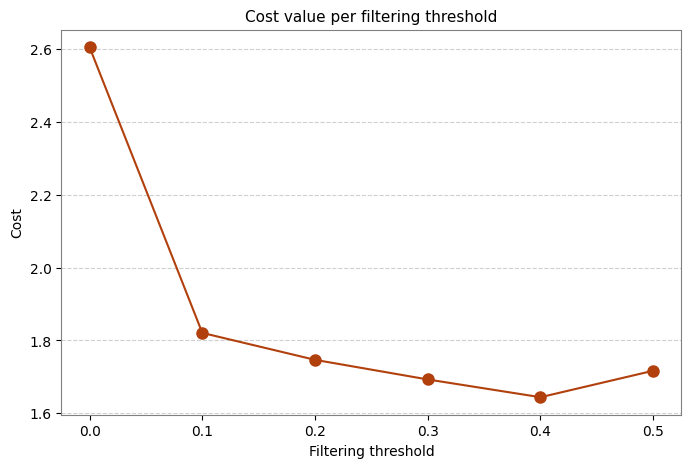

In [25]:
plot_cost_vs_tvalue(mini, 'firt_plot_hsl.pdf')

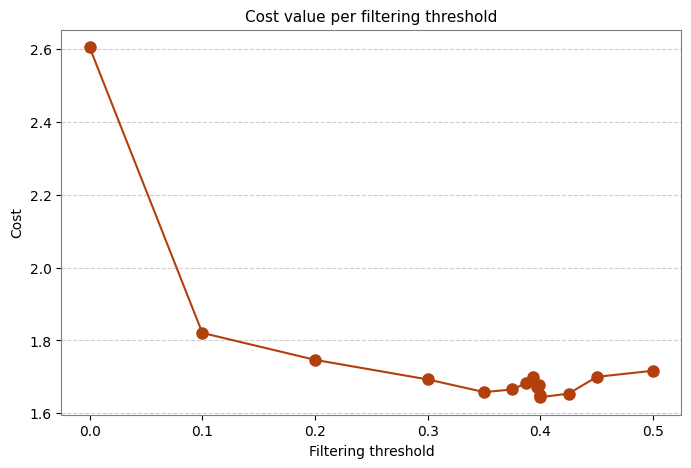

In [27]:
plot_cost_vs_tvalue(mini, 'plot_hsl.pdf')

In [30]:
tester = ThresholdsTester('hsl', 
                          splits_dir="splits_hsl", 
                          test_path='/home/ita/Documentos/pc-ita/tese-dados', 
                          test_name='hbp',
                          reports_dir='reports_hsl')

tester.final_results(t_value = 0.6, t2 = 0.96)

/tmp/ipykernel_4260/1782243101.py:189: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rejected.to_csv(f'{self.reports_dir}/rejected_{self.name}.csv', index=False, sep=',', encoding='utf-8', mode='w', line_terminator='\n')
/tmp/ipykernel_4260/1782243101.py:192: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  accepted.to_csv(f'{self.reports_dir}/accepted_{self.name}.csv', index=False, quoting=csv.QUOTE_NONNUMERIC, line_terminator="\n")


,threshold,T_value,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1,support_class_0,support_class_1,mean_confidence_class_0,mean_confidence_class_1,mean_confidence,percentage_classified_class_0,percentage_classified_class_1
0,0.96,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,1.0,0.771429,0.537500,0.686441,0.641791,0.726457,0.585034,118.0,67.0,0.639371,0.656305,0.645504,100.000000,100.000000
2,0.96,0.6,0.857143,0.622951,0.701299,0.808511,0.771429,0.703704,77.0,47.0,0.969813,0.980870,0.974004,65.254237,70.149254
3,0.00,0.6,0.770000,0.517647,0.652542,0.656716,0.706422,0.578947,118.0,67.0,0.932177,0.949076,0.938297,100.000000,100.000000
